# MORTALITY RATE

In this section, I will try to study more in details the mortality rate related to the COVID-19 pandemics. 
In particular, I will try to gain some understanding on the variation of the estimated mortality rate across countries using data from the [European Center for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) about the _ongoing global COVID-19 pandemic_ .

This is of particular importance since the measured values of the mortality rates $\hat{t}$ vary dramatically across countries due to a variety of reasons such as (but are not limited to) how much is the virus spread in the country and which kind of the measurements the country is taking in terms of testing. 

In order to address some of these problems, I have develop here a model for mortality rate based on **Bayesian ranking**, which allows me to compute mortality rates for each country and gives me credible confidence intervals that take into account the **information coming from the estimate of the mortality rates in other countries.**

To do so, let me define the total number of cases and causalities for each country respectively $N_c^{i}$ and $N_d^{i}$ and model the estimate of the mortality for COVID-19 in each country as:

\begin{equation}
\mathrm{P}\left ( t^{i} = \hat{t}^{i} |  N_c^{i}, N_d^{i} \right ) = \frac{\mathrm{P}\left (    N_c^{i}, N_d^{i} | t^{i} = \hat{t}^{i} \right ) \mathrm{P}\left ( t^{i} \right ) }{\int \mathrm{P} \left ( y \right ) \mathrm{P} \left (  N_c^{i}, N_d^{i} | y  \right ) dy  } 
\end{equation}
where $t^{i}$ is the mortality rate and $\hat{t}^{i}$ is its estimate. 

The conditional probability can be modeled as a Bernoulli trial over $N_c^{i}$, $N_d^{i}$ as: 
\begin{equation}
\mathrm{P}\left (   N_c^{i}, N_d^{i} | t^{i} = \hat{t}^{i} \right )  = \binom{N_d^{i}}{N_c^{i}} t^{N_d^{i}} (1-t)^{N_c^{i} - N_d^{i}}. 
\end{equation}

Let me choose for the moment $\mathrm{P}\left ( t^{i} \right ) = 1$, a uniform prior which will lead to an estimate of the mortality rate for each country that **is independent from the estimate of the mortality rates in other countries (which I will call here $\hat{t}^i_{C}$)**.

Using this prior we have:
\begin{equation}
\mathrm{P} \left ( t^{i}_{C} = \hat{t}^{i}_{C} |  N_d^{i}, N_c^{i} \right )   = \frac{t^{N_d^{i}}_{C} (1-t_{C})^{N_c^{i} - N_d^{i}}}{B\left ( N_d^{i}+1, N_c^{i}- N_d^{i} +1  \right )} = f_B \left ( t_{C}, N_d^{i}+1, N_c^{i} - N_d^{i} + 1 \right ),
\end{equation}

where $B(\alpha, \beta)$ is beta function with parameters $\alpha$ and $\beta$ and $f_B \left ( x, \gamma, \delta  \right )$ is the beta distribution function with parameters $\gamma$ and $\delta$.

This will allow me to easily compute the mortality rates and its **confidence interval by using the beta distribution.** In particular $\hat{t}^i_{C}$ will be the median of the beta distribution with parameters $N_c^{i}, N_d^{i}$ and its confidence interval will correspond to the 90 % interval of the distribution around the median value.  

Moreover, thanks to the Bayesian approach, we can easily introduce the **information about the estimate of the conversion rates in another countries by choosing another prior**. 

I have decided here* to introduce this information by choosing as a prior **a beta function with parameters $N^{T}_c$ , $N^{T}_d$, i.e. the total number of cases in the 20 most impacted countries by the COVID-19.** 
One could [demonstrate](https://www.chrisstucchio.com/blog/2013/bayesian_analysis_conversion_rates.html) that 
choosing a beta function as a prior gives
\begin{equation}
\mathrm{P} \left ( t^{i}_{T} = \hat{t}^{i}_{T} | N^{T}_d + N_d^{i}, N^{T}_c + N_c^{i} \right )   = f_B \left ( t_{T}, N_d^{i}+N^{T}_d+1, \left (N^{T}_c + N_c^{i}  \right ) - \left (N^{T}_d + N_d^{i}  \right ) + 1 \right ) 
\end{equation}

i.e. **another beta function with different parameters and where $\hat{t}^i_{T}$ is the estimate of the conversion rate for each country using the prior information about the 20 most impacted countries.**

In the next sections, I will compare $\hat{t}^i_{A}$ and $\hat{t}^i_{T}$ to try to shed some light on the variation of the estimated mortality rate across countries. 

*the beta function is chosen since it is mathematically easy to handle in the case and it corresponds to a "good distribution" for a binary outcome

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lmfit.models import ExponentialModel
from lmfit.models import StepModel

def fit_and_obtain_parameters(x,y,model):
    """
    Just a wrapper of lmfit fit to then obtain the best fit values. 
    """
    
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    
    values = np.array([])
    std_err = np.array([])
    
    for p in result.params:
        values = np.append(values,result.params[p].value)
        std_err = np.append(std_err,result.params[p].stderr)
        
        
    return values, std_err, result.redchi


def return_parameters_over_time(x,y,model,position_param=0,min_days=16):
    """
    A function which performs a fit per day (after min_days days)
    and returns the value and the standard error of the
    parameter in position position_param. 
    """
    
    values_param_per_day =  np.array([])
    stderr_param_per_day =  np.array([])
    rchi_per_day = np.array([])
    
    for j in range(min_days,len(y)):
        
        values, stds, red_chi = fit_and_obtain_parameters(x.head(j),
                                                 y.head(j),
                                                 model)
        
        values_param_per_day = np.append(values_param_per_day,values[position_param])
        stderr_param_per_day = np.append(stderr_param_per_day,stds[position_param])
        rchi_per_day = np.append(rchi_per_day, red_chi)
        
    
    return values_param_per_day, stderr_param_per_day, rchi_per_day

import scipy



def rate_estimate(x,n_bay_0=0,n_bay_1=0):
    rate = scipy.stats.beta.ppf(0.5 , 
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return rate

def confidence_beta_distribution(x, alpha=0.90, n_bay_0=0,n_bay_1=0):
    lower = scipy.stats.beta.ppf((1.0 - alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    upper = scipy.stats.beta.ppf((1.0 + alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return  upper - lower 


def create_df_country(df_world, country_name,n_bay_0=0,n_bay_1=0):
    """
    Create dataframe for country and order by days after first case. 
    """
    df_country = df_world[df_world["countriesAndTerritories"] == country_name]
    df_country["date_time_date"] = pd.to_datetime(df_country[["year", "month","day"]])
    
    df_country = df_country.sort_values("date_time_date",ascending=True)    
    df_country["Total_cumulative_Cases"] = df_country["cases"].cumsum()
    df_country["Total_cumulative_Deaths"] = df_country["deaths"].cumsum()
    df_country["mortality_rate"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate, axis=1)
    df_country["mortality_error"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution, axis=1)
    df_country["mortality_relative_error"] = df_country["mortality_error"] / df_country["mortality_rate"]
    df_country["mortality_rate_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate,
                                                                                                       axis=1,
                                                                                                       n_bay_0=n_bay_0,
                                                                                                       n_bay_1=n_bay_1)
    df_country["mortality_error_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution,
                                                                                                        axis=1,
                                                                                                        n_bay_0=n_bay_0,
                                                                                                        n_bay_1=n_bay_1)
    
    df_country = df_country[df_country["Total_cumulative_Cases"]>0]
    first_day = df_country["date_time_date"].iloc[0]
    df_country["number_days"] =  [abs((day - first_day).days) for day in df_country["date_time_date"]]
    
    return df_country

In [2]:
plt.rcParams['figure.figsize'] = [10, 8] #larger plots

As I have said in the previous section, the data are taken from European Center for Disease Prevention and Control and have to be _manually downloaded_ (at least as of today, 22/03/2020).

More refined data about the Italian situation can be found on the [great Github of the Protezione Civile](https://github.com/pcm-dpc/COVID-19) which is update daily and there exists also a [Kaggle competition with global data](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). 
However, I personally find data from ECPC more handy for cross-country comparison and that is why I use them here.

After loading the dataset, and I have create a dataframe for each country taken data starting from the **first day in which a case was observed in each one of these countries,** which roughly corresponds to beginning of the epidemy in the country of interest. 

Moreover, in order to able to compare results among different countries, I have created, for each dataset, a column called "number_days" which represents the days passed from the first case.  

In [3]:
df_world = pd.read_csv("COVID-19-geographic-disbtribution-worldwide-2020-04-03.csv")
df_world.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,4/3/2020,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
1,4/2/2020,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
2,4/1/2020,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
3,3/31/2020,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
4,3/30/2020,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0


In [4]:
top20_countries = df_world.groupby("countriesAndTerritories").sum().sort_values("cases", ascending=False).reset_index().head(20)["countriesAndTerritories"].tolist()

n_world_top20_cases = df_world[df_world["countriesAndTerritories"].isin(top20_countries)]["cases"].sum()
n_world_top20_death = df_world[df_world["countriesAndTerritories"].isin(top20_countries)]["deaths"].sum()

dict_of_df = {}

for country in top20_countries:
    
    df = create_df_country(df_world, country, n_bay_0=n_world_top20_death,n_bay_1=n_world_top20_cases)  

    dict_of_df[country] = df   

/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luca.albertorizzo/venv/Prediction_conversion_multi_channel/lib/python3.5/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

## Time dependence of the estimate of the mortality rate

Let me start by plotting  $\hat{t}^i_{A}$ for some of the most impacted countries as a function of the days after the first case measured in each country:

Text(0.5, 1.0, '$\\hat{t}^i_{A}$ per day')

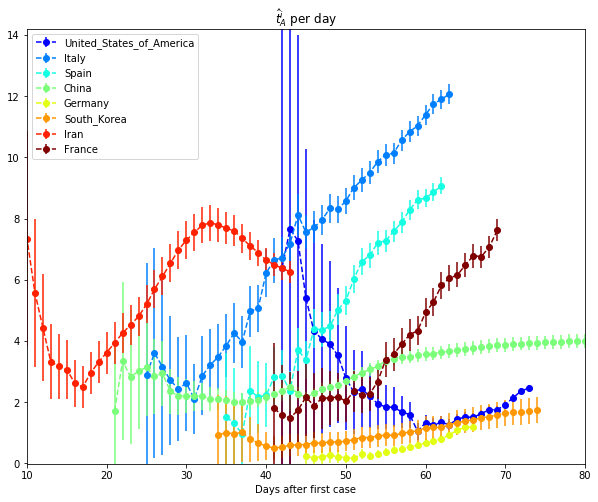

In [5]:
countries = ['United_States_of_America', 'Italy', 
             'Spain', 'China', 
             'Germany', 'South_Korea',
             'Iran','France']

cmap = plt.cm.get_cmap("jet", len(countries)+1)
i=0 

for country in countries:
    
    i+=1
    
    df = dict_of_df[country]
    df = df[df["mortality_relative_error"]<1.5]
    
    plt.errorbar(df["number_days"],
                 df["mortality_rate"]*100,
                 linestyle = '--',
                 marker = 'o',
                 color = cmap(i),
                 yerr = df["mortality_error"]*100,
                 ecolor = cmap(i),
                 label = country)
    
plt.legend()
plt.ylim(-0.01,14.2)
plt.xlim(10,80)
plt.xlabel("Days after first case")
plt.title("$\hat{t}^i_{A}$ per day")

where I have excluded the point for which the relative error on the mortality rate is higher than 1.5 to avoid noisy estimates. 
There are several interesting things about this plot: firstly, we can see that there a huge variety in the estimates among countries. This is due the fact that different countries are not only measuring differently the total number of infected cases and causalities but also are at different stages of the epidemics. 

Looking at the shape of the curves, we can see that there are at least 3 "stage of measurements" for the  mortality rates that corresponds roughly a to different phases of the epidemics (see also [here](https://ourworldindata.org/covid-testing)):

1. a fist phase in which the mortality rate decreases in time, which corresponds to a first phase of testing with a relative low number of causalities;
2. as the epidemics advances, the number of causality starts to grow "just exponentially" and the mortality rate increases very steadily because the number of tests grows less than the number of causalities (it is almost impossible to make the latter grow exponentially due to the very high "costs");  
3. a third phase (in which only few countries are as of today), in which the epidemics is more under control and the mortality rate decreases since there are less causalities and the same (or even more) number of tests, that corresponds to a decrease or to a stabilization of the mortality rate (see Iran or China).  

In particular, France, Italy and Spain have very high $\hat{t}^i_{A}$ since the number of causalities is still unfortunately growing very fast. On the other hand Germany and the USA started testing very aggressively at the beginning and now their mortality rates are increasing due to the growing number of causalities.

## $\hat{t}^i_{A}$ v.s. $\hat{t}^i_{T}$ plots


In this section I will compare $\hat{t}^i_{A}$ to $\hat{t}^i_{T}$ as of today 03/04/2020, to give some insight on which countries are under/over estimating their mortality rates. 

(4.5, 6.5)

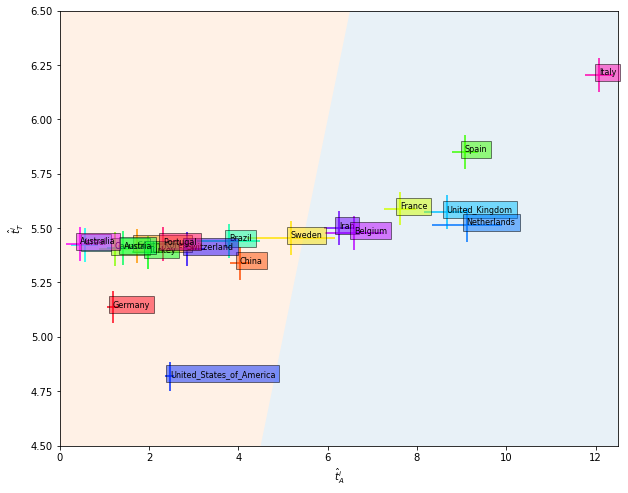

In [6]:
cmap = plt.cm.get_cmap("hsv", len(top20_countries)+1)


from random import shuffle

shuffle(top20_countries) #shuffling for better reading the colors on plots

x = np.arange(0,100) # just a straight line 

i=0
for country in top20_countries:
    
    i += 1
     
    plt.errorbar(100*dict_of_df[country].iloc[-1]["mortality_rate"], 
                 100*dict_of_df[country].iloc[-1]["mortality_rate_bayes"],
             linestyle = ' ',
             marker = ' ',
             xerr = 100*dict_of_df[country].iloc[-1]["mortality_error"],
             yerr = 100*dict_of_df[country].iloc[-1]["mortality_error_bayes"],
             label = country,
             color = cmap(i) )
    
    plt.text(100*dict_of_df[country].iloc[-1]["mortality_rate"], 
            100*dict_of_df[country].iloc[-1]["mortality_rate_bayes"],
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(i), alpha=0.5),
            rotation=0)
    
 

plt.xlabel('$\hat{t}^i_{A}$')
plt.ylabel('$\hat{t}^i_{T}$')
plt.fill_between(x,x,np.zeros(len(x)),alpha = 0.1)
plt.fill_between(x,x,10*np.ones(len(x)),alpha = 0.1)

plt.xlim(0.0,12.5)
plt.ylim(4.5,6.5)
#plt.legend(bbox_to_anchor=(1.0, 1.0)) 

In the previous plot, each point represents a country and on the x axis the we find the estimate of the mortality rate with a uniform prior (the "single-country" estimate) and on the y axis the estimate of the mortality rate with the beta function priors from the 20 most impacted countries. 

As we can see, the beta prior reduces dramatically the range of the estimate of the mortality rates and to a lesser extend to their confidence intervals. 

This is due to the fact that the estimate at a country level is **in general very poorly representative to the "global" one, due to the different phases of the epidemics.** In particular, countries for which $\hat{t}^i_{A}>\hat{t}^i_{T}$ (blue region) are probably **overestimating the conversion rate** due to the fact that high number of causalities while the opposite is true for countries in which $\hat{t}^i_{A}<\hat{t}^i_{T}$ (pink region) since they are in phase of the epidemics for which the number of causalities is low, either because they are towards the "beginning" (eg the USA) or toward the "end" (eg China) of the epidemics. 

The latter can be seen also by drawing the same plot with data taken two weeks ago, where the phase of mass testing in the USA and Germany had not yet started and the epidemics was much more under control in France and Spain): 

(5.25, 5.75)

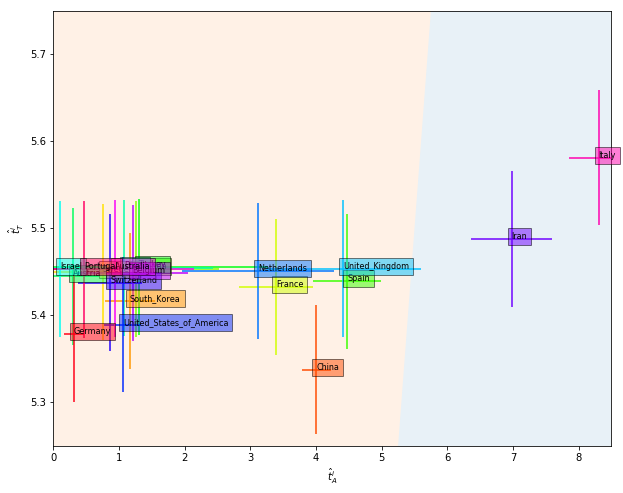

In [7]:
i=0
for country in top20_countries:
    
    i += 1
     
    plt.errorbar(100*dict_of_df[country].iloc[-15]["mortality_rate"], 
                 100*dict_of_df[country].iloc[-15]["mortality_rate_bayes"],
             linestyle = ' ',
             marker = ' ',
             xerr = 100*dict_of_df[country].iloc[-15]["mortality_error"],
             yerr = 100*dict_of_df[country].iloc[-15]["mortality_error_bayes"],
             label = country,
             color = cmap(i) )
    
    plt.text(100*dict_of_df[country].iloc[-15]["mortality_rate"], 
            100*dict_of_df[country].iloc[-15]["mortality_rate_bayes"],
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(i), alpha=0.5),
            rotation=0)
    
 

plt.xlabel('$\hat{t}^i_{A}$')
plt.ylabel('$\hat{t}^i_{T}$')
plt.fill_between(x,x,np.zeros(len(x)),alpha = 0.1)
plt.fill_between(x,x,10*np.ones(len(x)),alpha = 0.1)

plt.xlim(0.0,8.5)
plt.ylim(5.25,5.75)
#plt.legend(bbox_to_anchor=(1.0, 1.0)) 

As we can see, all countries have a $\hat{t}^i_{T}$  that is compatible with rest of the other countries since most of the countries were able to "correctly" estimate the mortality rate. 

From these plots we can draw some important conclusions about the mortality rates at the country level:
1. the mortality rate is **a time dependent quantity** and we should avoid using daily estimates to drawn any conclusion; 
2. during an epidemic, it is **very hard to test enough people to have a fair estimate of the mortality rate due to the fast growth in the number of causalities**; 
3. a Bayesian approach might be **very beneficial in comparing mortality rate across countries**, which will be of high importance in understanding better the confounders associated to the number of causalities (average age of the population, pollution, ...); 